<a href="https://colab.research.google.com/github/plaban1981/Langchain_usecases/blob/main/Best_Retrieval_models_for_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Best Retrieval models for Retrieval Augmented Generation(RAG)

* There are ebeding models which perform comparatively better than OpenAIEmbeddings model ada-002.
* Not everything works as per the embeddings model in the leaderboard.
* The real life usage decides which embedding models work better
* popular embedding models leaderboard is MTEB(Massive Text Embedding BenchMark (https://huggingface.co/spaces/mteb/leaderboard))

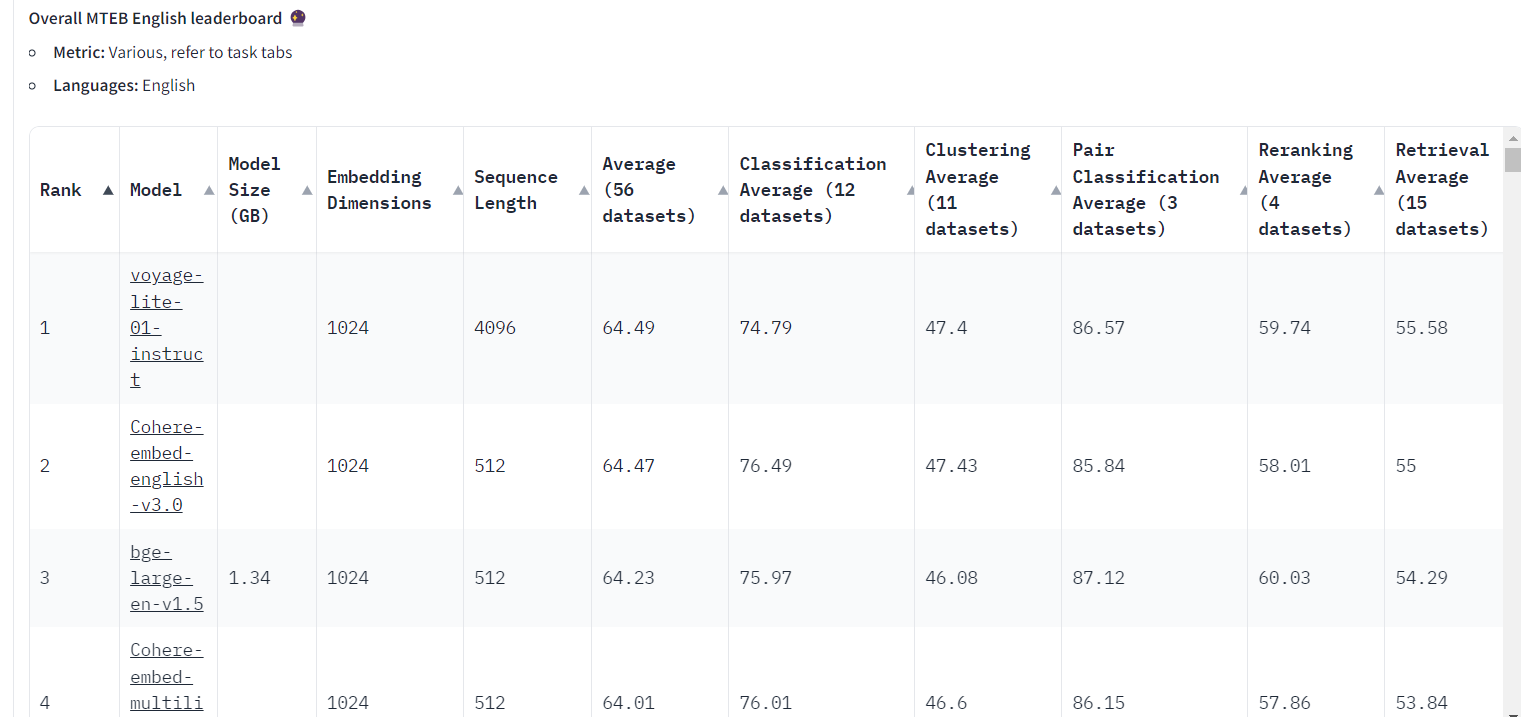

## Embedding Models we will look into
* Cohere/Cohere-embed-english-v3.0
* intfloat/e5-base-v2 ==> this model is not huge but works well

## Install Required Dependencies

In [ ]:
%%capture
! pip install -q datasets==2.14.6 openai==1.2.2 cohere==4.34 transformers==4.35.0

In [ ]:
%%capture
!pip install openai==0.28

## Download data

In [ ]:
from datasets import load_dataset
data = load_dataset('jamescalam/ai-arxiv-chunked',split='train')

In [ ]:
data

Dataset({
    features: ['doi', 'chunk-id', 'chunk', 'id', 'title', 'summary', 'source', 'authors', 'categories', 'comment', 'journal_ref', 'primary_category', 'published', 'updated', 'references'],
    num_rows: 41584
})

## Define Embedding Models

#### Openai Embeddings

In [ ]:
import os
from getpass import getpass
import openai
os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API Key: ")
openai.api_key = os.getenv("OPENAI_API_KEY")


Enter OpenAI API Key: ··········


In [ ]:
def embed(docs:list[str]) -> list[list[float]]:
  res = openai.Embedding.create(input=docs,model="text-embedding-ada-002")
  doc_embeds = [r.embedding for r in res.data]
  return doc_embeds

## Cohere Embedings

In [ ]:
import cohere
import os
from getpass import getpass
#
co = cohere.Client(getpass("Enter Cohere API Key: "))
#
def cohere_embed(docs:list[str]) -> list[list[float]]:
  doc_embeds = co.embed(docs,
                        input_type="search_document",
                        model='embed-english-v3.0')
  res = doc_embeds.embeddings
  return res



Enter Cohere API Key: ··········


## HuggingFace Embeddings

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
#
device = "cuda" if torch.cuda.is_available() else "cpu"
#
print(f"Using {device}")
#
tokenizer = AutoTokenizer.from_pretrained("intfloat/e5-base-v2")
model = AutoModel.from_pretrained("intfloat/e5-base-v2").to(device)
model.eval()

Using cpu


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [ ]:
def hf_embed(docs:list[str]) -> list[list[float]]:
  #prefix every token with passage to tell the model that this is a passage and not a query
  docs = [f"passage: {d}" for d in docs]
  #tokenize
  inputs = tokenizer(docs,
                     return_tensors="pt",
                     padding=True,
                     max_length=512,
                     truncation=True
                     ).to(device)
  with torch.no_grad():
    out = model(**inputs)
    hidden_state = out.last_hidden_state
    #max padding tokens
    last_hidden = hidden_state.masked_fill(inputs["attention_mask"][...,None].bool(),0.0)
    #
    #create mean pooled embeddings -turn all into a single embedding
    doc_embeds = last_hidden.sum(dim=1) / inputs["attention_mask"].sum(dim=1)[...,None]
    res = doc_embeds.cpu().numpy()
  return res

## Process embeddings

In [ ]:
data["chunk"][0:3]

['DistilBERT, a distilled version of BERT: smaller,\nfaster, cheaper and lighter\nVictor SANH, Lysandre DEBUT, Julien CHAUMOND, Thomas WOLF\nHugging Face\n{victor,lysandre,julien,thomas}@huggingface.co\nAbstract\nAs Transfer Learning from large-scale pre-trained models becomes more prevalent\nin Natural Language Processing (NLP), operating these large models in on-theedge and/or under constrained computational training or inference budgets remains\nchallenging. In this work, we propose a method to pre-train a smaller generalpurpose language representation model, called DistilBERT, which can then be ﬁnetuned with good performances on a wide range of tasks like its larger counterparts.\nWhile most prior work investigated the use of distillation for building task-speciﬁc\nmodels, we leverage knowledge distillation during the pre-training phase and show\nthat it is possible to reduce the size of a BERT model by 40%, while retaining 97%\nof its language understanding capabilities and being 

#### 1. Openai embeddings

In [ ]:
from tqdm.auto import tqdm
import numpy as np
#
chunks = data["chunk"]
batch_size =  256
for i in tqdm(range(0,len(chunks),batch_size)):
  i_end  = min(len(chunks),i+batch_size)
  chunk_batch = chunks[i:i_end]
  # embed current batch
  embed_batch = embed(chunk_batch)
  # add to existing np array if exists
  if i == 0:
    arr = np.array(embed_batch)
  else:
    arr = np.concatenate([arr,np.array(embed_batch)])


  0%|          | 0/163 [00:00<?, ?it/s]

In [ ]:
arr.shape

(41584, 1536)

## Build a query mechanism

In [ ]:
from numpy.linalg import norm
#
#convert chunks list to array for easy indexing
chunk_arr = np.array(chunks)
#
def query(text:str,top_k: int=3) -> list[str]:
  #create query embedding
  res = openai.Embedding.create(input=text,model="text-embedding-ada-002")
  xq = np.array(res.data[0].embedding)
  #calculate dot product similarity
  sim = np.dot(arr,xq.T)
  #get indices of top k records
  idx = np.argpartition(sim,-top_k)[-top_k:]
  print(sim[idx])
  docs = chunk_arr[idx]
  print(docs.shape)
  for d in docs.tolist():
    print(d)
    print("----------------------")


In [ ]:
query("why should i use llama 2")

[0.78111972 0.8172689  0.81056528]
(3,)
models will be released as we improve model safety with community feedback.
License A custom commercial license is available at: ai.meta.com/resources/
models-and-libraries/llama-downloads/
Where to send commentsInstructions on how to provide feedback or comments on the model can be
found in the model README, or by opening an issue in the GitHub repository
(https://github.com/facebookresearch/llama/ ).
Intended Use
Intended Use Cases L/l.sc/a.sc/m.sc/a.sc /two.taboldstyle is intended for commercial and research use in English. Tuned models
are intended for assistant-like chat, whereas pretrained models can be adapted
for a variety of natural language generation tasks.
Out-of-Scope Uses Use in any manner that violates applicable laws or regulations (including trade
compliancelaws). UseinlanguagesotherthanEnglish. Useinanyotherway
that is prohibited by the Acceptable Use Policy and Licensing Agreement for
L/l.sc/a.sc/m.sc/a.sc /two.taboldstyle.
Har

In [ ]:
query("what is the difference between gpt-4 and llama 2?")

[0.82866045 0.84211606 0.84723095]
(3,)
31.39%LLaMA-GPT4 
 25.99%
Tie 
 42.61%
HonestyAlpaca 
  25.43%LLaMA-GPT4 
 16.48%
Tie 
 58.10%
Harmlessness(a) LLaMA-GPT4 vs Alpaca ( i.e.,LLaMA-GPT3 )
 GPT4 
  44.11%
LLaMA-GPT4 
 42.78% Tie 
 13.11%
Helpfulness GPT4 
  37.48%
LLaMA-GPT4 
 37.88% Tie 
 24.64%
Honesty GPT4 
  35.36% LLaMA-GPT4 
 31.66% Tie 
 32.98%
Harmlessness
(b) LLaMA-GPT4 vs GPT-4
Figure 3: Human evaluation.
4.2 H UMAN EVALUATION WITH ALIGNMENT CRITERIA
To evaluate the alignment quality of our instruction-tuned LLMs, we follow alignment criteria from
Anthropic Askell et al. (2021): an assistant is aligned if it is helpful, honest, and harmless (HHH).
----------------------
(ii)For GPT-4 results alone, the translated responses show superior performance over the generated
response in Chinese, probably because GPT-4 is trained in richer English corpus than Chinese, which
leads to stronger English instruction-following ability. In Figure 5 (c), we show results for all models
who 

#### 2. Cohere Embeddings

In [ ]:
from tqdm.auto import tqdm
import numpy as np
#
chunks = data["chunk"]
batch_size =  15000
for i in tqdm(range(0,len(chunks),batch_size)):
  i_end  = min(len(chunks),i+batch_size)
  chunk_batch = chunks[i:i_end]
  # embed current batch
  embed_batch = cohere_embed(chunk_batch)
  # add to existing np array if exists
  if i == 0:
    arr = np.array(embed_batch)
  else:
    arr = np.concatenate([arr,np.array(embed_batch)])


  0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

#### HF embeddings

In [ ]:
from tqdm.auto import tqdm
import numpy as np
#
chunks = data["chunk"]
batch_size =  256
for i in tqdm(range(0,len(chunks),batch_size)):
  i_end = min(len(chunks),i+batch_size)
  chunk_batch = chunks[i:i_end]
  # embed current batch
  embed_batch = hf_embed(chunk_batch)
  # add to existing np array if exists
  if i == 0:
    hf_arr = embed_batch.copy()
  else:
    hf_arr = np.concatenate([arr,embed_batch.copy()])


  0%|          | 0/163 [00:00<?, ?it/s]

ValueError: ignored

####HF-create query mechanism

In [ ]:
from numpy,linalg import norm
#
#convert chunks list to array for easy indexing
chunk_arr = np.array(chunks)
#
def query(text:str,top_k: int=3) -> list[str]:
  #create query embedding
  xq = hf_embed([f"query: {text}"])[0]
  #calculate cosine similarities
  sim = np.dot(hf_arr,xq.T) / (norm(arr,axis=1) * norm(xq.T))
  #get indices of top k records
  idx = np.argpartition(sim,-top_k)[-top_k:]
  docs = chunk_arr[idx]
  for d in docs.tolist():
    print(d)
    print("----------------------")


3.